In [1]:
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from itertools import product

In [2]:
class CapacitatedQueue:
    '''
    A queue with maximum capacity. If any items are added when at capacity, then oldest items are pushed out.
    '''
    collection = []  # items in this collection
    capacity = 128   # max capacity
    next_ind = 0     # index of the next item to be added
    
    def __init__(self, capacity=128):
        '''
        Intializes this model
        INPUT
            capacity; the maximum capacity of this colleciotn
        '''
        self.capacity = capacity
        self.next_ind = 0
        self.collection = []
        
    def __len__():
        '''
        RETURNS length of the collection
        '''
        return len(self.collection)
        
    def add(self, item):
        '''
        Adds the given item into the collection.
        If the collection is at capacity, push out oldest item
        '''
        # If not at capacity, add in item
        if len(self.collection) < self.capacity:
            self.collection.append(item)
            
        # If at capacity, replace oldest item
        else:
            self.collection[self.next_ind] = item
            
        # Track the index of the next/oldest item
        self.next_ind = (self.next_ind + 1) % self.capacity

    def sample(self, size=1):
        '''
        RETURNS a (with-replacement) sample of the given size from the collection
        '''
        return np.random.choice(self.collection, size, replace=True).tolist()
    
    def get_next(self):
        '''
        RETURNS the next item in the collection
        '''
        return self.collection[(next_ind - 1) % self.capacity]

In [158]:
from copy import deepcopy

class VersusLearner:
    '''
    Class for approximating V function for a two player, zero-sum, symetrical game
    '''
    env = None              # associated envionment
    estimator = None        # the fitted function to estimate V, like a neural network
    replay_memory = None    # replay memory
        
    def __init__(self, env, estimator, replay_capacity=10**4):
        '''
        Intializes this object
        INPUT
            env; environment
            estimator; trainable function to estimate V
            replay_capacity; size of replay memory
        '''
        self.env = env
        self.estimator = estimator
        self.replay_memory = CapacitatedQueue(replay_capacity)
        
    def lookahead(self, discount_factor=0.99, env=None):
        '''
        Looks at the resulting states from all legal actions.
        INPUT
            discount_factor; amount to discount the value of next state when computing greedy action selection
            env; the environment to lookahead in
        RETURNS
            the action that results in the highest-value next state
            the estimated value of the highest-value next state
        '''
        # Initialize
        next_states = []
        rewards = []
        terminateds = []
        
        # Set the environment
        stored_env = None
        if env is not None:
            stored_env = self.env
            self.env = env
        
        # Lookahead for each action's outcome
        legal_actions = self.env.get_legal_actions()
        for act in legal_actions:
            lookahead_env = deepcopy(self.env)
            next_state, reward, terminated = lookahead_env.step(act)
            next_state = self.env.parse_board(next_state)
            next_states.append(next_state)
            rewards.append(reward)
            terminateds.append(terminated)
        
        # Format outcomes
        nonterminateds = (1 - np.array(terminateds)).astype(bool)      
        next_states = [ns for ind, ns in enumerate(next_states) if nonterminateds[ind]]
        next_states = np.array(next_states).reshape([len(next_states)] + list(self.env.get_observation_space_shape()))
        
        # Bootstrap the value of the next states
        action_values = np.array(rewards, dtype=float)
        if np.sum(nonterminateds):
#             print(rewards)
#             print(action_values)
#             print(next_states)
            action_values[nonterminateds] += -discount_factor * self.estimator.predict(next_states, verbose=0)[:, 0]
          
        # Replace the original environment
        if stored_env is not None:
            self.env = stored_env
        
        # Return
        return legal_actions[np.argmax(action_values)], np.max(action_values)
        
        
    def get_action(self, epsilon=0., discount_factor=0.99):
        '''
        Gets the action to take
        INPUT
            epsilon; the epsilon-greedy parameter
                if 0; plays full greedy
            discount_factor; amount to discount the value of next state when computing greedy action selection
        RETURNS
            action to take
        '''
        # Explore
        if (epsilon > 0) and (np.random.uniform() < epsilon):
            return random.choice(self.env.get_legal_actions())
                
        # Greedy
        best_action, _ = self.lookahead(discount_factor)
        return best_action
            
    def train(self, n_steps=10**3, epsilon=0.2, training_delay=32, batch_size=32, discount_factor=0.99):
        '''
        Trains this model
        INPUT
            n_steps; number of steps to train
            epsilon; epsilon-greedy threshold
            training_delay; number of steps to train before fitting approximator
            batch_size; number of frames to train approximator with
            discount_factor; discount factor in bellman
        RETURNS
            list of episode rewards
        '''
        # Initialize
        episode_counter = 0
        delay_counter = 0
        reward_history = [0]
        
        # First state
        self.env.reset()
        
        # Train for each step
        pbar = tqdm(range(n_steps))
        for _ in pbar:
            
            # Get action
            action = self.get_action(epsilon)
            
            # Make step
            _, reward, terminated = self.env.step(action)
            
            # Save frame
            if not terminated:
                self.replay_memory.add(deepcopy(self.env))
            reward_history[-1] += -self.env.player * reward
            
            # If terminated, record reward and reset
            if terminated:
#                 self.env.env.render()
#                 print(reward_history[-1])
                self.env.reset()
                pbar.set_description(f"Last episode reward: {reward_history[-1]}")
                pbar.update()
                reward_history.append(0)
                
            # If training_delay steps have occurred, then train
            delay_counter += 1
            if delay_counter >= training_delay:
                delay_counter = 0
                
                # Get minibatch of replayed states
                env_batch = self.replay_memory.sample(batch_size)
                states = []
                targets = []
                for lookahead_env in env_batch:
                    states.append(self.env.parse_board(lookahead_env.get_state()))
                    _, best_act_val = self.lookahead(discount_factor, lookahead_env)
                    targets.append(best_act_val)
                    
                # Train
                states = np.array(states).reshape([batch_size] + list(self.env.get_observation_space_shape()))
                targets = np.array(targets)
                self.estimator.fit(states, targets, epochs=1, verbose=0)
        
        return reward_history

In [8]:
from abc import ABC, abstractmethod

class VersusEnv(ABC):
    '''
    Abstract interface for approximating V function for a two player, zero-sum, symetrical game
    '''
    
    @abstractmethod
    def __init__(self, **kwargs):
        '''
        Initializes the environment
        '''
        pass
    
    @abstractmethod
    def reset(self):
        '''
        Resets the environment
        '''
        pass
    
    @abstractmethod
    def step(self, action):
        '''
        Takes the given action to step in the environment
        '''
        pass
    
    @abstractmethod
    def get_state(self):
        '''
        RETURNS the current environment state
        '''
        pass
    
    @abstractmethod
    def get_observation_space_shape(self):
        '''
        RETURNS the shape of the observation input space
        '''
        pass

    @abstractmethod
    def get_legal_actions(self):
        '''
        RETURNS list of legal actions in the current state
        '''
        pass
    
    @abstractmethod
    def parse_board(self, board):
        '''
        Parses the current state for neural network input
        '''
        pass

In [9]:
# from gym_connect4_master.connect4_env import Connect4Env as C4Env
from gym_tictactoe_master.tictactoe_env import TicTacToeEnv as TTTEnv

class VersusTicTacToe(VersusEnv):
    
    env = None  # Game environment
    player = 1  # Player index; either 1 or -1
    
    def __init__(self, **kwargs):
        '''
        Initializes the environment
        '''
        self.env = TTTEnv(kwargs)
        self.env.small = 0.
        self.env.large = 1.
        self.player = 1
        
    def reset(self):
        '''
        Resets the environment
        '''
        state, _ = self.env.reset()
        self.player = 1
        return state
    
    def step(self, action):
        '''
        Has current player play the given action
        INPUT
            action; a 2D-array of the location to play
        '''
        # Flatten
        flat_action = np.arange(0, 9, 1).reshape(3, 3)[action]
        
        # Step
        state, reward, terminated, _ = self.env.step((flat_action, (self.player + 1) / 2 + 1))
        
        # Check ties
        if np.sum(state == 0) == 0:
            terminated = True
        self.player = -self.player
        return state, reward, terminated
    
    def get_state(self):
        '''
        RETURNS current environment state
        '''
        return self.env.state
    
    def get_observation_space_shape(self):
        '''
        RETURNS shape of the observation space (3x3 grid with 2 color channels)
        '''
        return (3, 3, 2)
    
    def get_legal_actions(self):
        '''
        RETURNS list of coordinates that are currently blank
        '''
        legal_actions = [(row, col) for row, col in product(range(3), range(3))
               if self.env.state[row, col] == 0]
        return legal_actions
    
    def parse_board(self, board):
        '''
        Parses board such that the current player has 1 and opponent has -1 marks
        '''
        reshaped = board.reshape(3, 3)
        parsed = np.zeros((3, 3, 2))
        parsed[reshaped == (self.player + 1) / 2 + 1, 0] = 1
        parsed[reshaped == (-self.player + 1) / 2 + 1, 1] = 1
        return parsed

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Env
ttt_env = VersusTicTacToe()

# Build the model
model = Sequential([
    Input(shape=(3, 3, 2)),
    Conv2D(16, kernel_size=(2, 2), activation='relu'),
    Conv2D(8, kernel_size=(2, 2), activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(loss='mse',
              optimizer='adam')

# Model summary
model.summary()

# Initialize
ttt_learner = VersusLearner(ttt_env, model)
reward_history = []

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 2, 2, 16)          144       
                                                                 
 conv2d_23 (Conv2D)          (None, 1, 1, 8)           520       
                                                                 
 flatten_11 (Flatten)        (None, 8)                 0         
                                                                 
 dense_33 (Dense)            (None, 32)                288       
                                                                 
 dense_34 (Dense)            (None, 16)                528       
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,497
Trainable params: 1,497
Non-train

In [37]:
reward_history += ttt_learner.train(n_steps=10**3, epsilon=0.5)
reward_history += ttt_learner.train(n_steps=10**3, epsilon=0.3)
reward_history += ttt_learner.train(n_steps=10**3, epsilon=0.1)
reward_history += ttt_learner.train(n_steps=10**4, epsilon=0.01)

Last episode reward: 0.0: 100%|██████████| 10000/10000 [15:20<00:00, 10.86it/s]


In [51]:
reward_history += ttt_learner.train(n_steps=10**4, epsilon=0.01)

Last episode reward: 1.0: 100%|██████████| 10000/10000 [14:55<00:00, 11.17it/s]


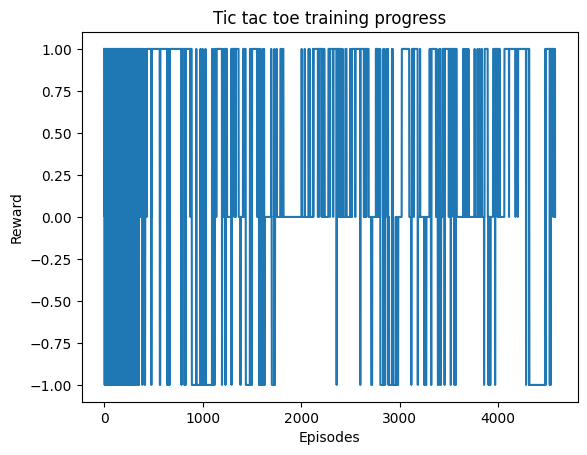

In [52]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Tic tac toe training progress")
plt.show()

In [58]:
model.save_weights('./checkpoints/tictactoe0')

In [128]:
ttt_env.reset()
print(ttt_env.env.render())
# print(ttt_learner.estimator.predict(state.reshape(1, 3, 3, 2), verbose=0))
print()
while True:
    _, _, terminated = ttt_env.step(ttt_learner.get_action(epsilon=0.))
    print(ttt_env.env.render())
#     print(ttt_learner.estimator.predict(state.reshape(1, 3, 3, 2), verbose=0))
    print(ttt_env.player)
    print()
    state = ttt_env.parse_board(raw_state, 1)
    if terminated:
        break    

╒═══╤═══╤═══╕
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
╘═══╧═══╧═══╛

╒═══╤═══╤═══╕
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
├───┼───┼───┤
│ - │ O │ - │
╘═══╧═══╧═══╛
-1

╒═══╤═══╤═══╕
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
├───┼───┼───┤
│ X │ O │ - │
╘═══╧═══╧═══╛
1

╒═══╤═══╤═══╕
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
├───┼───┼───┤
│ X │ O │ O │
╘═══╧═══╧═══╛
-1

╒═══╤═══╤═══╕
│ - │ - │ X │
├───┼───┼───┤
│ - │ - │ - │
├───┼───┼───┤
│ X │ O │ O │
╘═══╧═══╧═══╛
1

╒═══╤═══╤═══╕
│ - │ - │ X │
├───┼───┼───┤
│ - │ - │ O │
├───┼───┼───┤
│ X │ O │ O │
╘═══╧═══╧═══╛
-1

╒═══╤═══╤═══╕
│ - │ - │ X │
├───┼───┼───┤
│ - │ X │ O │
├───┼───┼───┤
│ X │ O │ O │
╘═══╧═══╧═══╛
1



In [167]:
from gym_connect4_master.connect4_env import Connect4Env as C4Env

class VersusConnect4(VersusEnv):
    
    env = None  # Game environment
    player = 1  # Player index; either 1 or -1
    
    def __init__(self):
        '''
        Initializes the environment
        '''
        self.env = C4Env()
        self.player = 1
        
    def reset(self):
        '''
        Resets the environment
        '''
        self.player = 1
        return self.env.reset()
    
    def step(self, action):
        '''
        Has current player play the given action
        INPUT
            action; column of the location to play
        '''
        state, reward, terminated, _ = self.env.step(action)
        self.player = -self.player
        return state, self.player * reward[1], terminated
    
    def get_state(self):
        '''
        RETURNS current environment state
        '''
        return self.env.board
    
    def get_observation_space_shape(self):
        '''
        RETURNS shape of the observation space (7x6 grid with 2 color channels)
        '''
        return (7, 6, 2)
    
    def get_legal_actions(self):
        '''
        RETURNS list of coordinates that are currently blank
        '''
        return self.env.get_moves()
    
    def parse_board(self, board):
        '''
        Parses board such that the current player has 1 and opponent has -1 marks
        '''
        perspective_obs = obs[int((-c4_env.player + 1) / 2)]
        state = [perspective_obs[1,:,:], perspective_obs[2,:,:]]
        state = np.array(state).reshape(7, 6, 2)
        return state

In [168]:
# Env
c4_env = VersusConnect4()

# Build the model
model = Sequential([
    Input(shape=(7, 6, 2)),
    Conv2D(16, kernel_size=(3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(loss='mse',
              optimizer='adam')

# Model summary
model.summary()

# Initialize
c4_learner = VersusLearner(c4_env, model)
reward_history = []

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 5, 4, 16)          304       
                                                                 
 conv2d_61 (Conv2D)          (None, 3, 2, 16)          2320      
                                                                 
 flatten_30 (Flatten)        (None, 96)                0         
                                                                 
 dense_90 (Dense)            (None, 32)                3104      
                                                                 
 dense_91 (Dense)            (None, 16)                528       
                                                                 
 dense_92 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,273
Trainable params: 6,273
Non-train

In [169]:
reward_history += c4_learner.train(n_steps=10**3, epsilon=0.5)
reward_history += c4_learner.train(n_steps=10**3, epsilon=0.3)
reward_history += c4_learner.train(n_steps=10**3, epsilon=0.1)
reward_history += c4_learner.train(n_steps=10**3, epsilon=0.01)

Last episode reward: 1: 100%|██████████| 1000/1000 [01:23<00:00, 11.92it/s]


In [173]:
reward_history += c4_learner.train(n_steps=10**4, epsilon=0.01)

Last episode reward: 1: 100%|██████████| 10000/10000 [14:46<00:00, 11.27it/s]


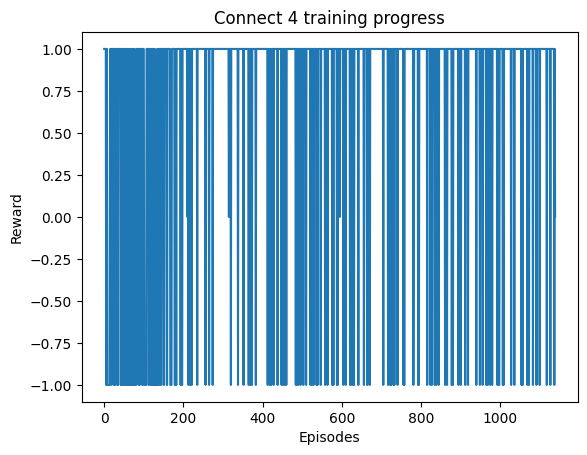

In [174]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Connect 4 training progress")
plt.show()

In [175]:
c4_env.reset()
c4_env.env.render()
# print(c4_learner.estimator.predict(state.reshape(1, 3, 3, 2), verbose=0))
print()
while True:
    _, _, terminated = c4_env.step(c4_learner.get_action(epsilon=0.))
    c4_env.env.render()
#     print(c4_learner.estimator.predict(state.reshape(1, 3, 3, 2), verbose=0))
#     print(c4_env.player)
    print()
    state = c4_env.parse_board(raw_state)
    if terminated:
        break    

.......
.......
.......
.......
.......
.......


.......
.......
.......
.......
.......
X......


.......
.......
.......
.......
O......
X......


.......
.......
.......
X......
O......
X......


.......
.......
O......
X......
O......
X......


.......
X......
O......
X......
O......
X......


O......
X......
O......
X......
O......
X......


O......
X......
O......
X......
O......
XX.....


O......
X......
O......
X......
OO.....
XX.....


O......
X......
O......
XX.....
OO.....
XX.....


O......
X......
OO.....
XX.....
OO.....
XX.....


O......
XX.....
OO.....
XX.....
OO.....
XX.....


OO.....
XX.....
OO.....
XX.....
OO.....
XX.....


OO.....
XX.....
OO.....
XX.....
OO.....
XXX....


OO.....
XX.....
OO.....
XX.....
OOO....
XXX....


OO.....
XX.....
OO.....
XX.....
OOO....
XXXX...


